In [3]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
import numpy as np
import random
import torch
import bayesflow as bf
import matplotlib.pyplot as plt
import pandas as pd
from keras import Model
from keras.layers import Dense, LSTM
from keras.initializers import RandomNormal

from data_utils import DataSimulator
from metrics import multimodel_accuracy
from losses import multimodel_lpop_exponential_loss
from Motion import *

In [7]:
print(f"Using Keras backend: {keras.backend.backend()}")

print("CUDA available:", torch.cuda.is_available())
print("GPU device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

np.random.seed(17)
random.seed(17)
torch.manual_seed(17)

Using Keras backend: torch
CUDA available: True
GPU device: NVIDIA GeForce RTX 4080 Laptop GPU


In [3]:
# Define simulator models
days = 100
time = days/365
steps = days

fc_simulator_geom = Motion("geom", "fc", time=time, num_steps=steps)
diag_simulator_geom = Motion("geom", "diag", time=time, num_steps=steps)
sph_simulator_geom = Motion("geom", "sph", time=time, num_steps=steps)
fc_simulator_arith = Motion("arith", "fc", time=time, num_steps=steps)
diag_simulator_arith = Motion("arith", "diag", time=time, num_steps=steps)
sph_simulator_arith = Motion("arith", "sph", time=time, num_steps=steps)


def norm_wrapper(sim):
    data = sim()['motion']
    data = np.clip(data, a_min=1e-8, a_max=None)
    log_ret = np.log(data[1:] / data[:-1])
    return log_ret

def x0(): 
    return 

brownian_models = [
    lambda s : [norm_wrapper(fc_simulator_geom) for _ in range(s)],
    lambda s : [norm_wrapper(diag_simulator_geom) for _ in range(s)],
    lambda s : [norm_wrapper(sph_simulator_geom) for _ in range(s)],
    lambda s : [norm_wrapper(fc_simulator_arith) for _ in range(s)],
    lambda s : [norm_wrapper(diag_simulator_arith) for _ in range(s)],
    lambda s : [norm_wrapper(sph_simulator_arith) for _ in range(s)]
]


In [4]:
print(brownian_models[0](1))

[array([[-9.13882490e-02, -6.68483035e-02, -8.21316741e-02],
       [-1.66083646e-01, -8.33838839e-02, -2.08999944e-01],
       [-5.38044356e-02, -4.69666609e-02, -6.94472743e-02],
       [ 2.68327452e-02,  5.36847072e-02,  2.35001180e-02],
       [ 9.41421061e-02,  1.36194965e-02,  8.76296115e-02],
       [ 6.15041636e-02,  3.02294450e-02,  9.49869135e-03],
       [-6.71599640e-02, -4.93416672e-02, -5.07885107e-02],
       [-7.33558214e-02, -4.19153270e-02, -7.37774634e-02],
       [ 3.59415453e-02,  2.38431004e-02,  4.86243489e-02],
       [-4.82750266e-02, -2.75497059e-02, -1.52960507e-03],
       [ 1.03092481e-01, -6.71749467e-03,  1.51463225e-01],
       [ 9.26907860e-02,  7.21688288e-02,  9.64577137e-02],
       [-2.43139325e-02,  4.80314864e-02,  9.76501916e-02],
       [ 1.24818791e-01,  1.08243589e-01,  1.33463171e-01],
       [-8.73628793e-02, -3.97425757e-02, -3.94522901e-02],
       [-9.30053657e-02, -2.58910069e-02, -5.22361936e-02],
       [ 4.68819097e-02, -2.85498207e-0

In [ ]:
# Network
class BayesEvidenceNetwork(Model):
    def __init__(self, num_models, **kwargs):
        super().__init__(**kwargs)

        self.summary_network = LSTM(128, return_sequences=False)
        self.classification_network = bf.networks.MLP(
            widths=[128] * 4, activation="silu", dropout=None)

        self.output_layer = Dense(num_models-1, activation=None,
                                  kernel_initializer=RandomNormal(mean=0.0, stddev=0.01)) 

    def call(self, x, training=False):
        x = self.summary_network(x, training=training)
        x = self.classification_network(x, training=training)
        return self.output_layer(x)


In [6]:
# Data Preparation

BATCH_SIZE = 144
TRAIN_BATCHES = 144
VAL_BATCHES = 8
EPOCHS = 30

train_loader = DataSimulator(
    batches_per_epoch=TRAIN_BATCHES,
    simulators=brownian_models,
    batch_size=BATCH_SIZE,
)

# Validation loader
val_loader = DataSimulator(
    batches_per_epoch=VAL_BATCHES,
    simulators=brownian_models,
    batch_size=BATCH_SIZE,
)

In [7]:
# Compile model

lr_schedule = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=5e-5, decay_steps=EPOCHS * len(train_loader)
)
optimizer = keras.optimizers.AdamW(learning_rate=lr_schedule)

model = BayesEvidenceNetwork(len(brownian_models))

model.compile(
    optimizer=optimizer,
    loss=multimodel_lpop_exponential_loss,
    metrics=[multimodel_accuracy]
)

In [8]:
# Train model

with torch.enable_grad(): 
    history = model.fit(
        train_loader,
        validation_data=val_loader,
        epochs=EPOCHS,
        verbose=1
    )

Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 43s 294ms/step - loss: 5.9999 - multimodel_accuracy: 0.1621 - val_loss: 5.9989 - val_multimodel_accuracy: 0.1667
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 77s 537ms/step - loss: 5.4018 - multimodel_accuracy: 0.2024 - val_loss: 5.0304 - val_multimodel_accuracy: 0.2665
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 44s 306ms/step - loss: 5.0546 - multimodel_accuracy: 0.2617 - val_loss: 5.5167 - val_multimodel_accuracy: 0.2179
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 45s 315ms/step - loss: 5.5826 - multimodel_accuracy: 0.2175 - val_loss: 5.5961 - val_multimodel_accuracy: 0.2205
Epoch 5/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 86s 598ms/step - loss: 5.5569 - multimodel_accuracy: 0.2204 - val_loss: 5.5794 - val_multimodel_accuracy: 0.2231
Epoch 6/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 129s 900ms/step - loss: 5.5393 - multimodel_accuracy: 0.2225 - val_loss: 5.5645 - val_multimodel_accuracy: 0.2222
Epoch 7/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 129s 899ms/step - loss: 5.5432 - multimod

In [9]:
num_models = len(brownian_models)
cm = np.zeros((num_models, num_models), dtype=int)

# Fill confusion matrix
for idx, func in enumerate(brownian_models):
    X_test = np.array(func(100))
    y_test = np.full((X_test.shape[0], 1), idx, dtype=np.int32)

    f_x = model.predict(X_test[:, :], verbose=0)

    y_pred = np.argmax(f_x, axis=1)

    for true_label, pred_label in zip(y_test.flatten(), y_pred):
        cm[true_label, pred_label] += 1

    acc = np.mean(y_pred == y_test.flatten())
    print(f"Model {idx} accuracy: {acc*100:.2f}%")

# Pretty print confusion matrix
print("\nConfusion Matrix:")
header = "Predicted ->\t" + "\t".join([f"{i}" for i in range(num_models)])
print(header)
for i in range(num_models):
    row = "\t".join([str(cm[i, j]) for j in range(num_models)])
    print(f"True {i}:     \t{row}")

Model 0 accuracy: 67.00%
Model 1 accuracy: 0.00%
Model 2 accuracy: 0.00%
Model 3 accuracy: 0.00%
Model 4 accuracy: 0.00%
Model 5 accuracy: 0.00%

Confusion Matrix:
Predicted ->	0	1	2	3	4	5
True 0:     	67	0	0	33	0	0
True 1:     	60	0	0	40	0	0
True 2:     	63	0	0	37	0	0
True 3:     	100	0	0	0	0	0
True 4:     	100	0	0	0	0	0
True 5:     	100	0	0	0	0	0



Loss History


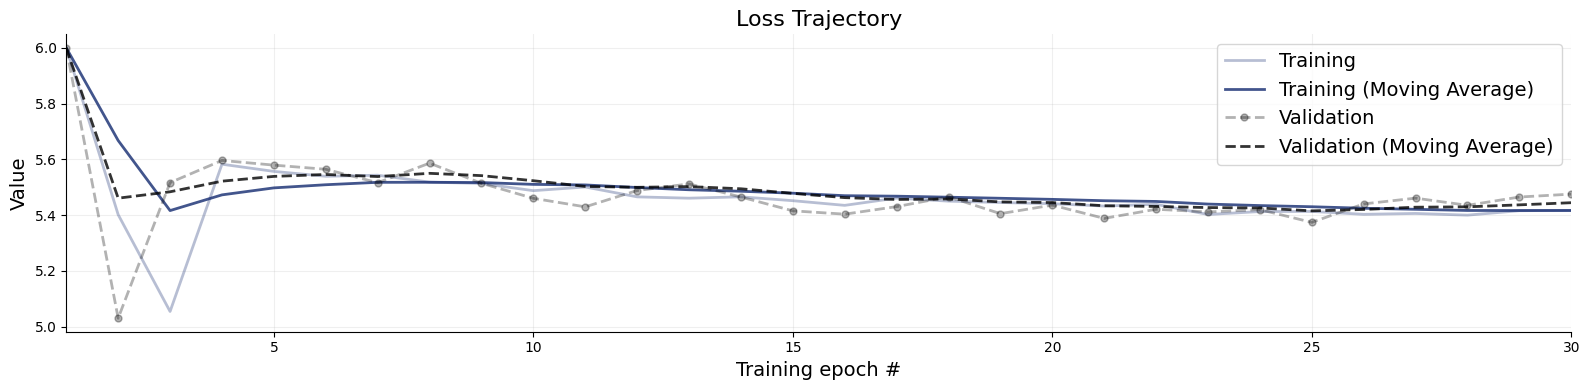

In [10]:
print(f"\nLoss History")
bf.diagnostics.plots.loss(history=history)
plt.show()